In [6]:
import torch
import os
import pathlib
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch.utils.data import Subset
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Load Data

1875 313


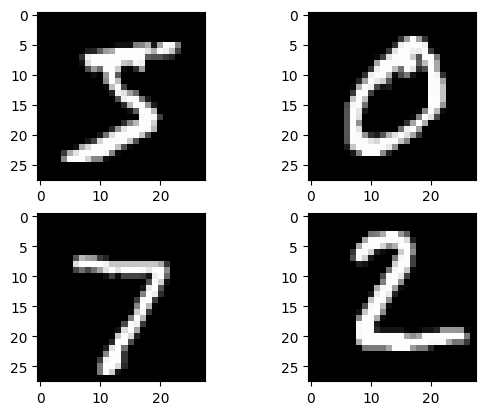

In [33]:

# download the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# plot samples
num_samples = 2
sample_train = train.data[:num_samples]
sample_test = test.data[:num_samples]

fig, axs = plt.subplots(2, num_samples)
for i, sample in enumerate(sample_train):
    axs[0, i].imshow(sample.numpy(), cmap='gray')
for i, sample in enumerate(sample_test):
    axs[1, i].imshow(sample.numpy(), cmap='gray')

# Adjust subset size here, so you can reduce the training time
subset_size = int(1 * len(train))
indices = torch.randperm(len(train))[:subset_size]
train = Subset(train, indices)
subset_size = int(1 * len(test))
indices = torch.randperm(len(test))[:subset_size]
test = Subset(test, indices)    

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print(len(train_loader), len(test_loader))

# Define Noising Function

In [34]:
def generate_noise_progression(alpha_t, X, times):
    assert times.shape[0] == X.shape[0]
    epsilon = torch.randn(X.shape).to(X.device) 
    alpha_hat_t = (alpha_t ** times).view(-1, 1, 1, 1)
    return torch.sqrt(alpha_hat_t) * X + (epsilon * torch.sqrt(1 - alpha_hat_t))

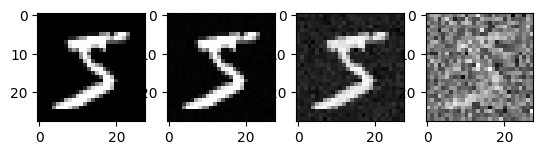

In [35]:
times = [0, 100, 500, 1000]
noised_sample = generate_noise_progression(0.99, sample_train[0].unsqueeze(0).repeat(len(times), 1,1, 1), torch.tensor(times))
fig, axs = plt.subplots(1, len(times))
for i, sample in enumerate(noised_sample):
    (axs[i].imshow
     (sample[0].numpy(), cmap='gray'))

# Define Model

In [36]:
model = UNet2DModel(in_channels=1,
                     out_channels=1,
                     act_fn="gelu",
                     block_out_channels=(128, 128, 256, 512),
                     down_block_types=(
                         "DownBlock2D",
                         "DownBlock2D",
                         "AttnDownBlock2D",
                         "DownBlock2D",
                     ),
                     up_block_types=(
                         "UpBlock2D",
                         "AttnUpBlock2D",
                         "UpBlock2D",
                         "UpBlock2D",
                     )

                     ).to(device)

Iteration 0, Loss 0.04367087781429291
Iteration 1, Loss 0.04630983993411064
Iteration 2, Loss 0.042300835251808167
Iteration 3, Loss 0.05248149484395981
Iteration 4, Loss 0.04454004019498825
Iteration 5, Loss 0.040681373327970505
Iteration 6, Loss 0.05295252054929733
Iteration 7, Loss 0.053565606474876404
Iteration 8, Loss 0.048128239810466766
Iteration 9, Loss 0.04317016154527664
Iteration 10, Loss 0.05151201784610748
Iteration 11, Loss 0.053413473069667816
Iteration 12, Loss 0.04859311878681183
Iteration 13, Loss 0.04514850676059723
Iteration 14, Loss 0.049475543200969696
Iteration 15, Loss 0.052360981702804565
Iteration 16, Loss 0.0471516028046608
Iteration 17, Loss 0.045281216502189636
Iteration 18, Loss 0.04946838319301605
Iteration 19, Loss 0.0452367439866066
Iteration 20, Loss 0.03998266160488129
Iteration 21, Loss 0.0509830042719841
Iteration 22, Loss 0.05040423572063446
Iteration 23, Loss 0.04392554610967636
Iteration 24, Loss 0.04266989976167679
Iteration 25, Loss 0.043103024

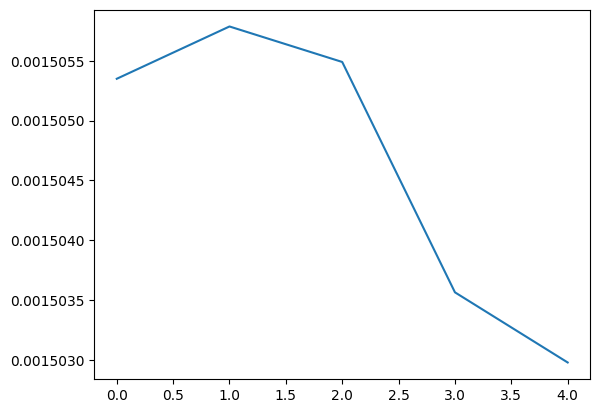

In [38]:
if os.path.exists("./models/model.pth"):
    model  = torch.load("./models/model.pth").to(device)
    print("Model already trained and loaded from file 'models/model.pth'")
    print("If you would like to retrain your model, delete 'models/model.pth' and run this cell again.")
else:
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    
    num_epochs = 5
    T = 1000
    alpha_t = 0.99
    
    model.train()
    train_loss_evolution = []
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            times = torch.randint(2, T, size=(x.shape[0],)).to(device)
            noised_x = generate_noise_progression(alpha_t, x, times)
            x_hat = model(noised_x, times).sample
            
            loss = F.mse_loss(x_hat, x)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            print("Iteration {}, Loss {}".format(i, loss.item()))
        train_loss_evolution.append(train_loss / len(train))
        print(f'Epoch {epoch + 1} loss: {train_loss / len(train)}')
        
    plt.plot(train_loss_evolution)
    pathlib.Path('./models').mkdir(exist_ok=True)
    torch.save(model, "./models/model.pth")
    
        
        
    

# Test

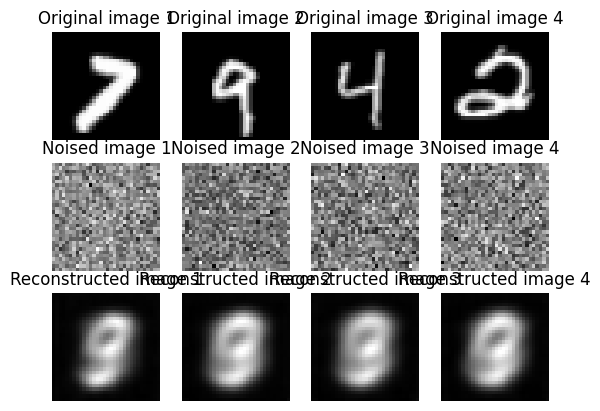

Iteration 0, Loss 0.048436447978019714
Iteration 1, Loss 0.04883023351430893
Iteration 2, Loss 0.040942199528217316
Iteration 3, Loss 0.048730626702308655
Iteration 4, Loss 0.046778395771980286
Iteration 5, Loss 0.040685832500457764
Iteration 6, Loss 0.0508153960108757
Iteration 7, Loss 0.0418366938829422
Iteration 8, Loss 0.05231654644012451
Iteration 9, Loss 0.047063350677490234
Iteration 10, Loss 0.04452430456876755
Iteration 11, Loss 0.04626287892460823
Iteration 12, Loss 0.05532286316156387
Iteration 13, Loss 0.04723888263106346
Iteration 14, Loss 0.0530565083026886
Iteration 15, Loss 0.0491805374622345
Iteration 16, Loss 0.05109444633126259
Iteration 17, Loss 0.04571538418531418
Iteration 18, Loss 0.048263028264045715
Iteration 19, Loss 0.04461248219013214
Iteration 20, Loss 0.0431390106678009
Iteration 21, Loss 0.04912455379962921
Iteration 22, Loss 0.04707751423120499
Iteration 23, Loss 0.04994335025548935
Iteration 24, Loss 0.04704754054546356
Iteration 25, Loss 0.047209717333

In [41]:
test_loss = 0
num_images = 4
fig, axs = plt.subplots(3, num_images)
model.eval()
for i, (x, _) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        times = torch.randint(2, T, size=(x.shape[0],)).to(device)
        noised_x = generate_noise_progression(alpha_t, x, times)
        x_hat = model(noised_x, times).sample
        loss = F.mse_loss(x_hat, x)
        test_loss += loss.item()
        if i == 0:
            x = x.detach().cpu().squeeze()
            noised_x = noised_x.detach().cpu().squeeze()
            x_hat = x_hat.detach().cpu().squeeze()
            for idx, ax in enumerate(axs[0]):
                ax.imshow(x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Original image {idx + 1}')
            for idx, ax in enumerate(axs[1]):
                ax.imshow(noised_x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Noised image {idx + 1}')
            for idx, ax in enumerate(axs[2]):
                ax.imshow(x_hat[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Reconstructed image {idx + 1}')
            plt.show()
    print("Iteration {}, Loss {}".format(i, loss.item()))
print(f'Test loss: {test_loss / len(test)}')
    

# Generate

In [42]:
generated_images = []
num_images = 100
with torch.no_grad():
    x_t = torch.randn([num_images, 1, 32, 32]).to(device)
    for t in reversed(range(2, T)):
        timestep = torch.tensor([t]).repeat(num_images).to(device)
        x_theta = model(x_t, timestep).sample
        alpha_bar_t = (alpha_t ** timestep).view(-1, 1, 1, 1)
        alpha_bar_t_1 = alpha_t ** (timestep-1).view(-1, 1, 1, 1)
        sqrt_alpha_t = torch.sqrt(torch.tensor(alpha_t).view(-1, 1, 1, 1)).to(device)
        mu_theta = 1 / (1 - alpha_bar_t) * (sqrt_alpha_t * (1 - alpha_bar_t_1) * x_t + torch.sqrt(alpha_bar_t_1) * (1 - alpha_t) * x_theta)
        x_t = mu_theta + ((1 - alpha_t) * (1 - alpha_bar_t_1) / (1 - alpha_bar_t)) * torch.randn(num_images).view(-1, 1, 1, 1).to(device)
    generated_images = x_t.detach().cpu().squeeze().squeeze().numpy()

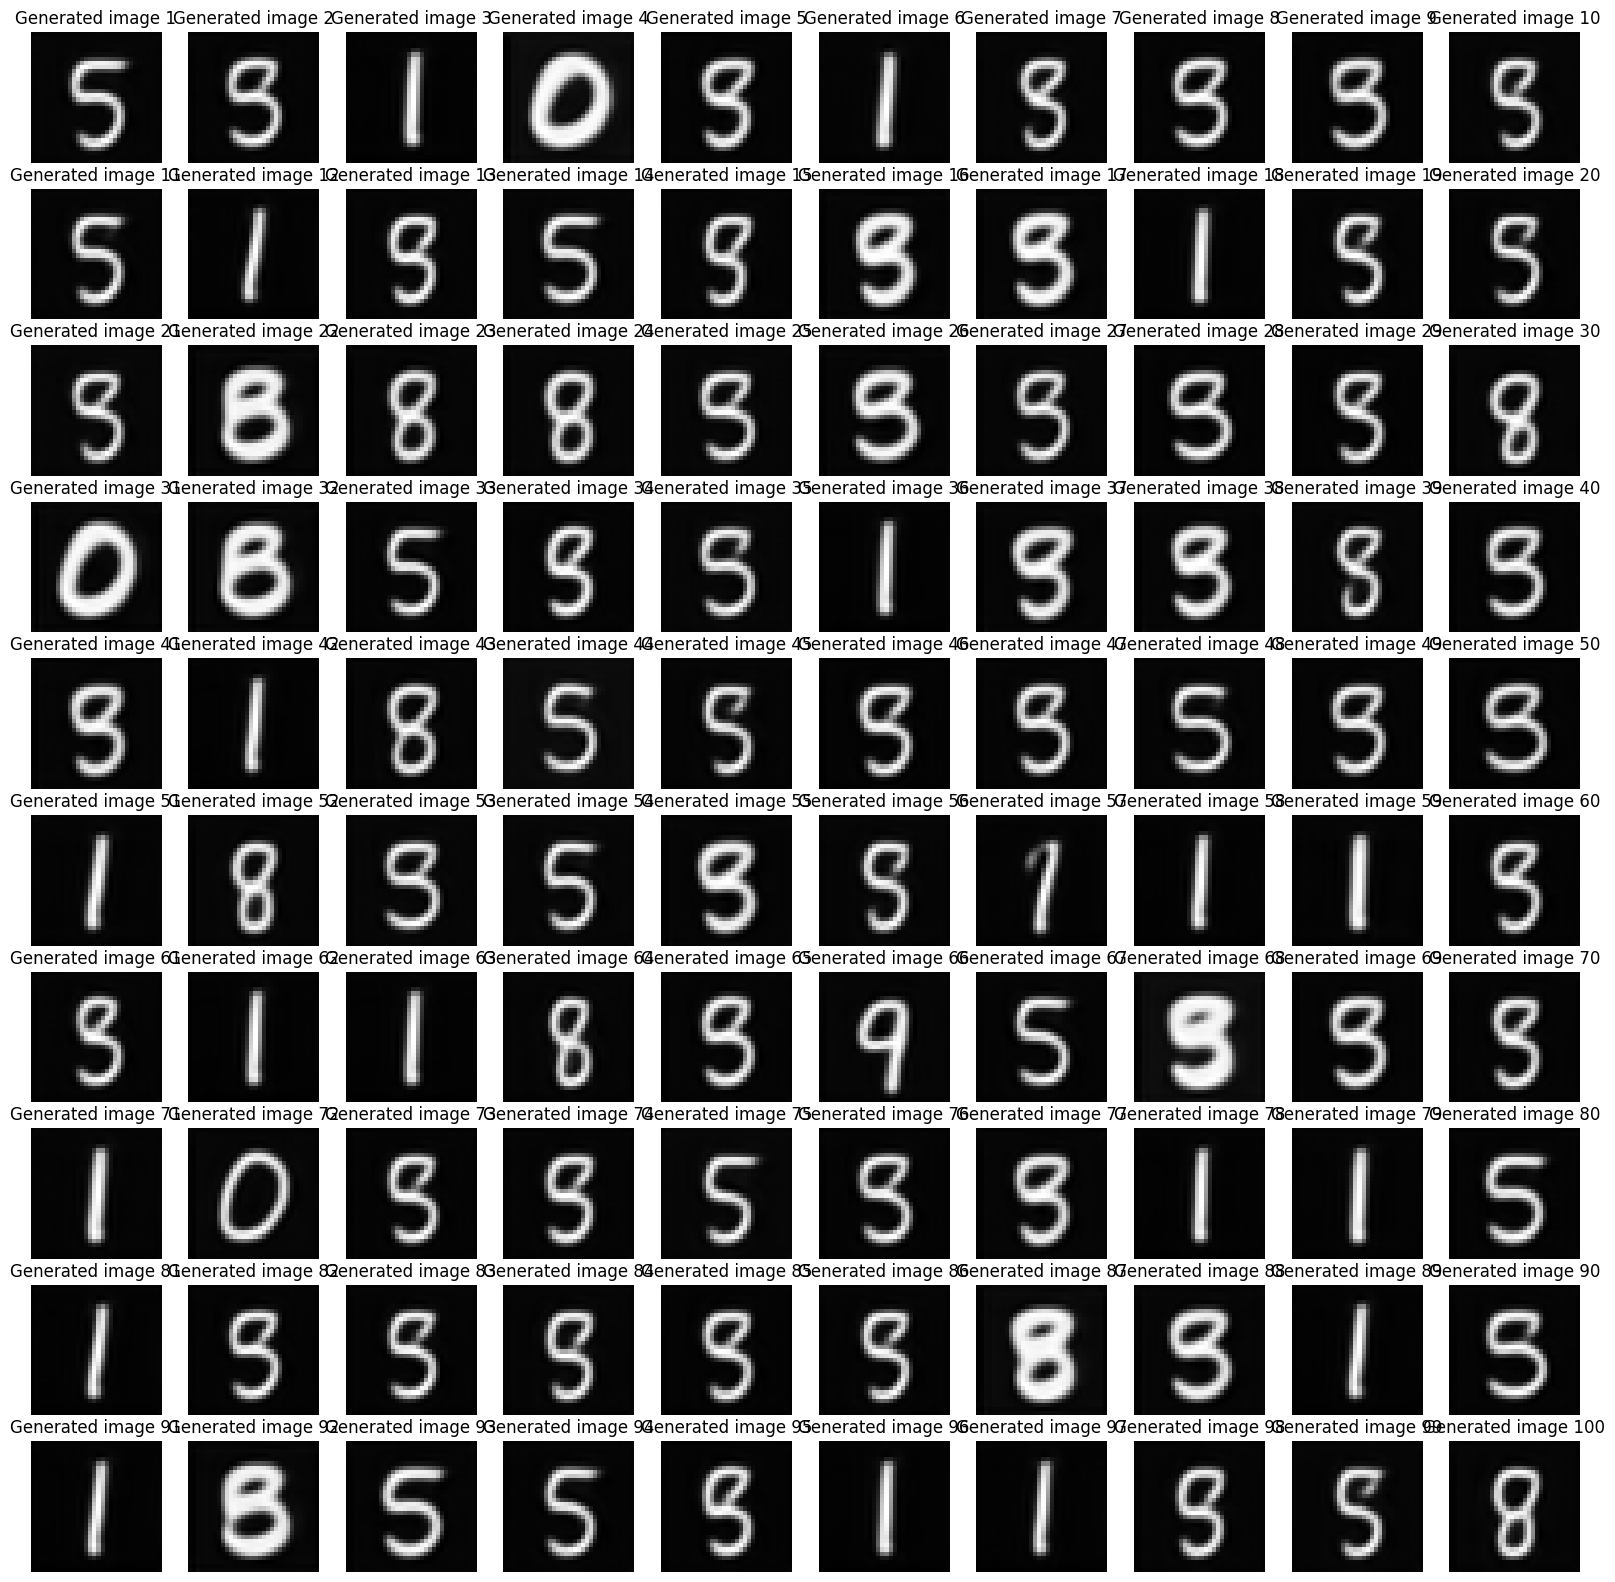

In [43]:
# Visualize the output

fig, axes = plt.subplots(nrows=10, ncols=int(num_images/10), figsize=(20, 20))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()